In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

In [184]:
TeV_OFF= pd.read_csv('../data/EvtList_OFF_TeV2032.txt', sep=' ')

In [185]:
TeV_ON= pd.read_csv('../data/EvtList_ON_TeV2032.txt', sep=' ')

Primero miraremos si nos llegan rayos gamma desde las proximadedes de la posición del pulsar PSR J2032+414, que es donde apuntabamos con el telescopio.

Para eso, podemos seguir los pasos de Leyre en la página 3 de su noche cuando mira si tiene señal de Mrk 421. Daniel, Alba y Quim también lo hacen para sus fuentes. Es lo primero que todos hacemos con los datos una vez nos hemos asegurado de entender que son, que información tienen y en que condiciones fueron tomados. Pero Daniel, Alba y Quim usaban funciones ya definidas para simplificar el código necesario o datos pretratados. Ahora ya sabemos como hacerlo desde zero, así que seguiremos a Leyre.

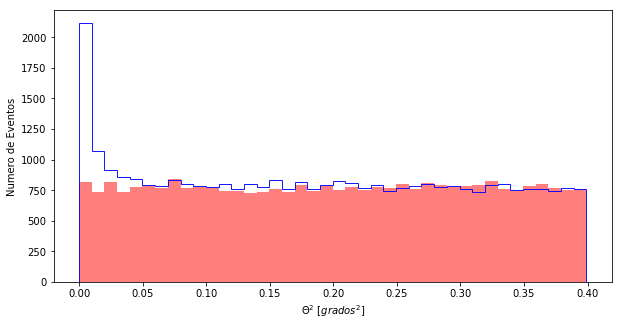

[ 813.  731.] [ 2114.  1069.] 23.8388967377


In [190]:
# Definimos la variables de corte had_cut y theta_cut:
had_cut =0.2
theta2_cut_plot = 0.40

# Seleccionamos los datos:
TeV_ON_cut = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_plot)]
TeV_OFF_cut = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_plot)]


# Mostramos los eventos ON y OFF en un gráfico:
pl.figure(1, figsize=(10, 5), facecolor='w', edgecolor='k')
Noff, ThetasOff, _ = pl.hist(TeV_OFF_cut.theta2, bins=40, histtype='stepfilled', color='red', alpha=0.5, normed=False)
Non, ThetasOn, _ = pl.hist(TeV_ON_cut.theta2, bins=40, histtype='step', color = 'blue',alpha=0.9, normed=False)
pl.xlabel('$\Theta^2$ [$grados^2$]')
pl.ylabel('Numero de Eventos')
pl.show()


En este caso, hemos tomado el OFF de forma simultanea al ON. Eso se hace usando un método que se llama wobble que consiste en apuntar ligeramente desviado y usar la región simétrica a donde queda la fuente, como el OFF. Así que no necesitamos normalizar. Ya lo está.

Esta claro que hay señal!!! Y mucha ... 

Pero vamos a ver de donde viene esta emisión y si viene todo desde un mismo sitio.

Para hacerlo, podemos seguir los pasos de Quim en la página 5 de su noche, cuando hace el Sky Map para ver si a parte de su querido Perseus hay algo más el campo de visión.

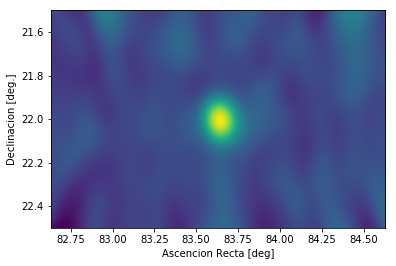

In [191]:
import scipy.ndimage as ndimage

# Seleccionamos los datos con un corte muy poco restrictivo en theta cuadrado:
theta2_cut_skymap = 3.50
TeV_ON_cut_skymap = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_skymap)]
TeV_OFF_cut_skymap = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_skymap)]


# Representamos el Skymap:
hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut_skymap.XCam, TeV_ON_cut_skymap.YCam, bins=71)
hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut_skymap.XCam, TeV_OFF_cut_skymap.YCam, bins=71)
#hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut.XCam, TeV_ON_cut.YCam, bins=71)
#hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut.XCam, TeV_OFF_cut.YCam, bins=71)
img1 = ndimage.gaussian_filter(hist_off, sigma=(5, 2), order=0)
img2 = ndimage.gaussian_filter(hist_crab, sigma=(5, 2), order=0)
hist_excess = np.subtract(img2, img1)
hist_excess = np.divide(hist_excess, img1)
pl.imshow(hist_excess, interpolation='gaussian',extent=[82.63,84.63,22.5,21.50],aspect="auto")
pl.xlabel('Ascencion Recta [deg]')
pl.ylabel('Declinacion [deg.]')
pl.show()

Pués parece que en este caso solo hay emisión desde la posició del pulsar.

El siguiente paso es ver si la cantidad de rayos gamma que llegan de esa región cambia con el tiempo.

Para esto, podemos hacer la Light Curve (Curva de luz) como hace Leyre en la página 3 de su noche.

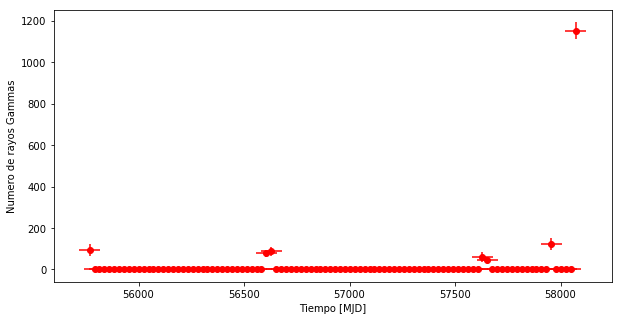

In [192]:
#Cómo calcular un Lightcurve:

# 1 Preparamos los datos teniendo en cuenta que los excesos los calculamos con:
#    a/ Después del corte en hadronness
#    b/ Usando los eventos en los dos primeros bin del Theta Plot, 
#       es decir Theta Cuadrado < 0.02
#    c/ Con el OFF y el ON normalizados
had_cut = 0.20
theta2_cut_excess = 0.02
TeV_ON_cut_LightCurve = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_excess)]
TeV_OFF_cut_LightCurve = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_excess)]

# 2 Calcular Non y Noff para cada intervalo de tiempo 
# Vamos a definir 100 intervalos (bins) a lo largo de nuestros datos
bins =100
Non, tiempos= np.histogram(TeV_ON_cut_LightCurve.Tiempo_dia, bins=bins)
Noff, bins_off= np.histogram(TeV_OFF_cut_LightCurve.Tiempo_dia, bins=tiempos)

# 3 Calcular el Exceso y su Error para cada intervalo de tiempo
Exceso= Non - Noff
Error= (Non + Noff)**0.5

# 4 Representar el lightcurve: los excesos con sus errores a lo largo del tiempo
pl.figure(3, figsize=(10, 5), facecolor='w', edgecolor='k')
pl.errorbar(tiempos[1:], Exceso, xerr=10000.0/(2.0*bins), yerr= Error, fmt='or', ecolor='red')
pl.xlabel('Tiempo [MJD]')
pl.ylabel('Numero de rayos Gammas')
pl.show()

Interesante! Parece que la emisión que nos llega desde la cercanías del sistema binario que contiene PSR J2032+410 es variable! Incluso que durante mucho días no emite nada.

Pero como hemos dicho al principio, lo primero (incluso antes de mirar si hay señal) es entender nuestros datos. Cuando Leyre hace la Light Curve:

1/ Tiene un conjunto de datos para el cual no hay interrupciones desde que empieza hasta que termina.

2/ Tiene un OFF con la misma distribución temporal.

Para nuestro caso, la segunda asumpción es correcta ya que como hemos dichos antes tomamos el OFF simultaneamente con el sistems del wobble, pero no la primera. 

Nuestro intervalo de tiempos son unos 2500 días. Es impossible tener un conjunto de datos de una fuente sin interrupciones con MAGIC. La tierra se mueve y la mayor parte del cielo (incluyendo la Nebulosa del Crab) no es visible durante todo el año, sino solo una parte. Además, MAGIC solo puede obervar de noche. Por tanto, 1/ es una asumción incorrecta.


En lugar de asumir que hay datos en todo el intervalo, podemos mirar la cantidad de rayos gamma que vemos cada día.

Para hacer esto, podemos usar un bucle sobre todos los días de forma parecida a lo que hace Quim en la página 4 de su noche para simular las 100000 observaciones.

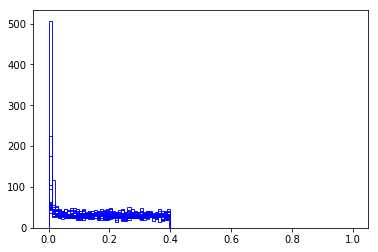

In [200]:
error = np.zeros(2500)
exceso = np.zeros(2500)
MJD = np.zeros(2500)

y=0

for x in range(0, 2500):
    mjd=x+55745
    TeV_ON_cut_dia = TeV_ON_cut[TeV_ON_cut['Tiempo_dia'] == mjd]
    TeV_OFF_cut_dia = TeV_OFF_cut[TeV_OFF_cut['Tiempo_dia'] == mjd]
    Non, ThetasOn, _ = pl.hist(TeV_ON_cut_dia.theta2, bins=40, histtype='step', color = 'blue',alpha=0.9, normed=False)
    eventos_on = sum(Non[1:39])
    if (eventos_on > 0 ) :
        TeV_ON_cut_LightCurve = TeV_ON_cut_dia[(TeV_ON_cut_dia['theta2'] < theta2_cut_excess)]
        EventosON = len(TeV_ON_cut_LightCurve)
        TeV_OFF_cut_LightCurve = TeV_OFF_cut_dia[(TeV_OFF_cut_dia['theta2'] < theta2_cut_excess)]
        EventosOFF = len(TeV_OFF_cut_LightCurve)

        error[y] = (EventosON+EventosOFF)**(0.5)
        exceso[y] = EventosON - EventosOFF
        MJD[y]=mjd
        y=y+1    

Y ahora solo nos falta mostrar la Light Curve con datos el número de gamma día a día

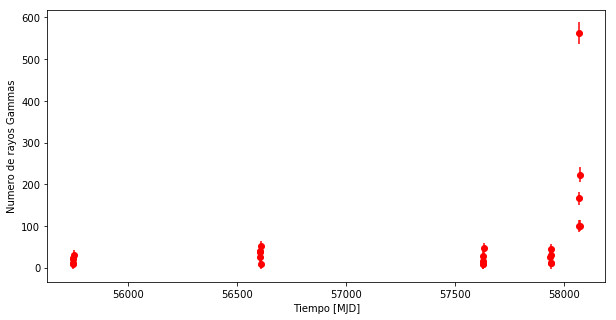

[   8.   12.   20.   23.   30.   41.   37.   26.    9.   52.   15.    9.
   29.    9.   46.   25.   30.   44.   12.   11.   99.  166.  562.  223.
  101.]


In [202]:
# 4 Representar el lightcurve: los excesos con sus errores a lo largo del tiempo
pl.figure(4, figsize=(10, 5), facecolor='w', edgecolor='k')
pl.errorbar(MJD[0:25], exceso[0:25], xerr=0.5, yerr= error[0:25], fmt='or', ecolor='red')
pl.xlabel('Tiempo [MJD]')
pl.ylabel('Numero de rayos Gammas')
pl.show()

print (exceso[0:25])

Esto ya tiene mejor pinta! Se puede ver que hemos obsevado en 5 periodos diferentes y que en el último, como mínimom en un día hay más emisión. Qué días créeis que es? Si, el día del periastro.

Está claro que en Noviembre hay más señal, nos llegan más rayos gamma. Pero quizás será más fácil de ver si hacemos el Light Curve con un solo punto para cada uno de los períodos que observamos.


/Users/blanch/Work/SoftwareTools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


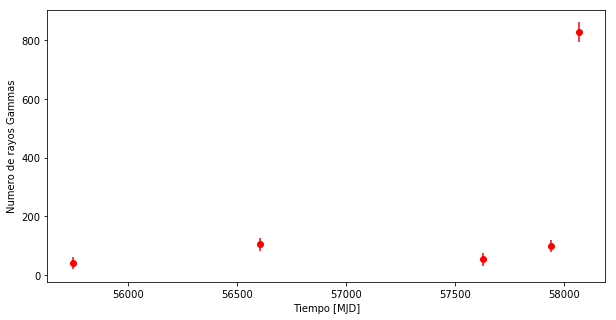

In [195]:
had_cut = 0.20
theta2_cut_excess = 0.02
TeV_ON_cut_LightCurve = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_excess)]
TeV_OFF_cut_LightCurve = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_excess)]

error = np.zeros(5)
exceso = np.zeros(5)
MJD = np.zeros(5)

startday = [55745,56604,57626,57937,58068]
endday = [55749,56608,57630,57941,58072]

for x in range(0, 5):
    mjd=startday[x]+2.5
    TeV_ON_cut_dia = TeV_ON_cut_LightCurve[(TeV_ON_cut_LightCurve['Tiempo_dia'] > startday[x]-1) & (TeV_ON_cut_LightCurve['Tiempo_dia'] < endday[x]-1)]
    TeV_OFF_cut_dia = TeV_OFF_cut_LightCurve[(TeV_OFF_cut['Tiempo_dia']  > startday[x]-1) & (TeV_OFF_cut_LightCurve['Tiempo_dia'] < endday[x]-1)]
    EventosON = len(TeV_ON_cut_dia)
    EventosOFF = len(TeV_OFF_cut_dia)
    error[x] = (EventosON+EventosOFF)**(0.5)
    exceso[x] = EventosON - EventosOFF
    MJD[x]=mjd  
 
pl.figure(5, figsize=(10, 5), facecolor='w', edgecolor='k')
pl.errorbar(MJD, exceso, xerr=2.5, yerr=error, fmt='or', ecolor='red')
pl.xlabel('Tiempo [MJD]')
pl.ylabel('Numero de rayos Gammas')
pl.show()   

Aparte de que haya más emisión, quizás hay otras diferencias. De hecho, podría ser que la emisión no viniera exactamente del mismo sitio. Miremos si los skymaps son diferentes entre la emisión en Noviemre del 2017 y la emisión que se veía anteriormente.

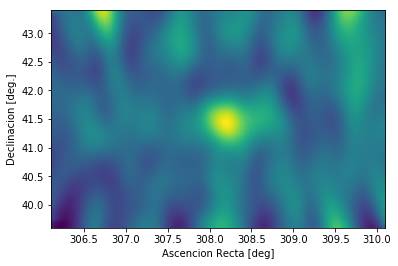

In [197]:
# Seleccionamos los datos con un corte muy poco restrictivo en theta cuadrado:
theta2_cut_skymap = 3.50
TeV_ON_cut_skymap = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_skymap) & (TeV_ON['Tiempo_dia'] > 55744) & (TeV_ON['Tiempo_dia'] < 57942)]
TeV_OFF_cut_skymap = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_skymap)& (TeV_OFF['Tiempo_dia'] > 55744) & (TeV_OFF['Tiempo_dia'] < 57942)]


# Representamos el Skymap:
hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut_skymap.XCam, TeV_ON_cut_skymap.YCam, bins=71)
hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut_skymap.XCam, TeV_OFF_cut_skymap.YCam, bins=71)
#hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut.XCam, TeV_ON_cut.YCam, bins=71)
#hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut.XCam, TeV_OFF_cut.YCam, bins=71)
img1 = ndimage.gaussian_filter(hist_off, sigma=(5, 2), order=0)
img2 = ndimage.gaussian_filter(hist_crab, sigma=(5, 2), order=0)
hist_excess = np.subtract(img2, img1)
hist_excess = np.divide(hist_excess, img1)
pl.imshow(hist_excess, interpolation='gaussian',extent=[306.1,310.1,39.6,43.4],aspect="auto")
pl.xlabel('Ascencion Recta [deg]')
pl.ylabel('Declinacion [deg.]')
pl.show()

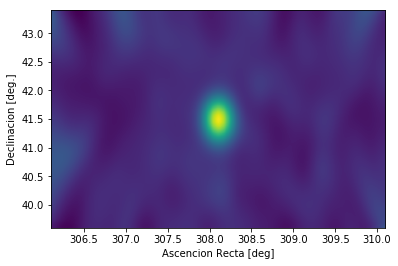

In [198]:
# Seleccionamos los datos con un corte muy poco restrictivo en theta cuadrado:
theta2_cut_skymap = 3.50
TeV_ON_cut_skymap = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_skymap) & (TeV_ON['Tiempo_dia'] > 58065) & (TeV_ON['Tiempo_dia'] < 58075)]
TeV_OFF_cut_skymap = TeV_OFF[(TeV_OFF['had'] < had_cut) & (TeV_OFF['theta2'] < theta2_cut_skymap)& (TeV_OFF['Tiempo_dia'] > 58065) & (TeV_OFF['Tiempo_dia'] < 58075)]


# Representamos el Skymap:
hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut_skymap.XCam, TeV_ON_cut_skymap.YCam, bins=71)
hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut_skymap.XCam, TeV_OFF_cut_skymap.YCam, bins=71)
#hist_crab, xedge, yedge = np.histogram2d(TeV_ON_cut.XCam, TeV_ON_cut.YCam, bins=71)
#hist_off, xedge, yedge = np.histogram2d(TeV_OFF_cut.XCam, TeV_OFF_cut.YCam, bins=71)
img1 = ndimage.gaussian_filter(hist_off, sigma=(5, 2), order=0)
img2 = ndimage.gaussian_filter(hist_crab, sigma=(5, 2), order=0)
hist_excess = np.subtract(img2, img1)
hist_excess = np.divide(hist_excess, img1)
pl.imshow(hist_excess, interpolation='gaussian',extent=[306.1,310.1,39.6,43.4],aspect="auto")
pl.xlabel('Ascencion Recta [deg]')
pl.ylabel('Declinacion [deg.]')
pl.show()

Pues parece que la emisión de antes de Noviembre del 2017 era más alargada y estaba un poco desplazada respecto el pulsar. Mientras que la de Noviembre del 2017 parece venir de la posicón del pulsar.

Ahora solo nos queda ver si el pulsar emite por si mismo rayos gamma.

Los pulsares tienen emisiones periódicas debido a que dan vueltas sobre si mismos con una frecuencia muy bien definida. Para el pulsar PSR J2031+410 el periodo es de 143 ms, que sabemos por observaciones en otras longitudes de onda. Con esto podemos calcular la phase para cada rayo gamma que detectamos. De hecho en los datos que tenemos, ya está calculada la fase.

En este caso, los valores de fase son continuos y al ser le periodo de 143 ms, mucho más pequeños que los tiempos de observación tenemos el mismos tiempo de observación para todas las fases.

Por tanto podemos usar una versión simplificada del cálculo de la Light Curve que hace Leyre en la página 3 de su noche.

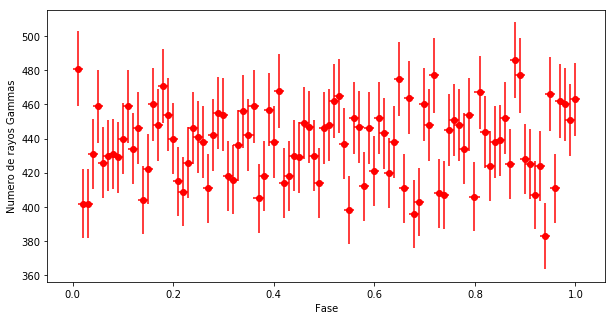

[481 402 402 431 459 426 430 431 429 440 459 434 446 404 422 460 448 471
 454 440 415 409 426 446 441 438 411 442 455 454 418 416 436 456 442 459
 405 418 457 438 468 414 418 430 429 449 447 430 414 446 448 462 465 437
 398 452 447 412 446 421 452 443 420 438 475 411 464 396 403 460 448 477
 408 407 445 451 448 434 454 406 467 444 424 438 439 452 425 486 477 428
 425 407 424 383 466 411 462 460 451 463]


In [199]:
#Cómo calcular un Lightcurve:

# 1 Preparamos los datos teniendo en cuenta que los excesos los calculamos con:
#    a/ Después del corte en hadronness
#    b/ Usando los eventos en los dos primeros bin del Theta Plot, 
#       es decir Theta Cuadrado < 0.02
#    c/ Con el OFF y el ON normalizados, en este caso no hace falta
had_cut = 1.0
theta2_cut_excess = 0.02
TeV_ON_cut_LightCurve = TeV_ON[(TeV_ON['had'] < had_cut) & (TeV_ON['theta2'] < theta2_cut_excess)]

# 2 Calcular Non y Noff para cada intervalo de tiempo 
# Vamos a definir 100 intervalos (bins) en los 10000 segundos de nuestros datos
bins =100
Non, tiempos= np.histogram(TeV_ON_cut_LightCurve.Fase, bins=bins)

# 3 Calcular el Exceso y su Error para cada intervalo de tiempo
Exceso = Non
Error = (Non)**0.5

# 4 Representar el lightcurve: los excesos con sus errores a lo largo del tiempo
pl.figure(5, figsize=(10, 5), facecolor='w', edgecolor='k')
pl.errorbar(tiempos[1:], Exceso, xerr=1/bins, yerr= Error, fmt='or', ecolor='red')
pl.xlabel('Fase')
pl.ylabel('Numero de rayos Gammas')
pl.show()

print (Exceso)

Que os parece, el pulsar emite rayos gamma por si solo? Parece que no, el hecho que la emisión que vemos venga de la posición del púlsar no quiere decir que sea el púlsar quien emite. Recordad que estamos en un sistema binario, puede ser la interacción del viento del pulsar con su compañera.

Y con esto hemos terminado nuestra noche. Muchas gracias por participar.

Ya has probado de resolver "Tu noche" de este año?